In [19]:
import warnings
warnings.filterwarnings('ignore')
import os
import sys
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import glob
import copy
import cartopy as cart
import cartopy.crs as ccrs
from pathlib import Path
import dask 
from os.path import join,expanduser
import sys
import time as time

# identify user's home directory
user_home_dir = expanduser('~')

# import the ECCOv4 py library 
sys.path.insert(0,join(user_home_dir,'ECCOv4-py'))
import ecco_v4_py as ecco

notebook_path = os.getcwd()

In [2]:
from dask.distributed import Client

#  connec to existing LocalCluster
# the port number will be different!
client = Client("tcp://127.0.0.1:32985") # click +new from the "stack" botton
client.ncores
client.restart()

Task exception was never retrieved
future: <Task finished name='Task-91498' coro=<Client._gather.<locals>.wait() done, defined at /srv/conda/envs/notebook/lib/python3.12/site-packages/distributed/client.py:2394> exception=AllExit()>
Traceback (most recent call last):
  File "/srv/conda/envs/notebook/lib/python3.12/site-packages/distributed/client.py", line 2403, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-91489' coro=<Client._gather.<locals>.wait() done, defined at /srv/conda/envs/notebook/lib/python3.12/site-packages/distributed/client.py:2394> exception=AllExit()>
Traceback (most recent call last):
  File "/srv/conda/envs/notebook/lib/python3.12/site-packages/distributed/client.py", line 2403, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-91481' coro=<Client._gather.<locals>.wait() done, defined at /srv/conda/envs/notebook/lib/p

In [127]:
## Load ECCO variables
# local path to monthly-mean native grid datasets
ecco_v4r5_mon_mean_native_dir = Path('/efs_ecco/ECCO/V4/r5/netcdf/native/mon_mean/')
ecco_v4r5_mon_mean_native_dataset_paths = np.sort(list(ecco_v4r5_mon_mean_native_dir.glob('*')))

nyear = 27 # the N-th year since 1992

# Select dataset 1 (the one containing temperature and flux)
dataset_num = 19 
TF_dataset_dir = ecco_v4r5_mon_mean_native_dataset_paths[dataset_num]
TF_dataset_files = np.sort(list(TF_dataset_dir.glob('*nc')))[nyear*12:nyear*12+12]

# Select dataset 2 (the one containing volume flux)
dataset_num = 22
UVW_dataset_dir = ecco_v4r5_mon_mean_native_dataset_paths[dataset_num]
UVW_dataset_files = np.sort(list(UVW_dataset_dir.glob('*nc')))[nyear*12:nyear*12+12]

# select geomotry data
geo_file = '/efs_ecco/ECCO/V4/r5/netcdf/native/geometry/GRID_GEOMETRY_ECCO_V4r5_native_llc0090.nc'
ecco_grid = xr.open_dataset(geo_file)

ecco_vars_uvw = xr.open_mfdataset(UVW_dataset_files, 
                                  parallel=True, data_vars='minimal',\
                                  coords='minimal',compat='override',
                                  combine='nested', concat_dim='time',
                                  chunks={'time':12, 'tile':13,' k':50,'j':90,'i':90})
ecco_vars_adv_th = xr.open_mfdataset(TF_dataset_files, 
                                     parallel=True, data_vars='minimal',\
                                     coords='minimal',compat='override',
                                     combine='nested', concat_dim='time',
                                     chunks={'time':12, 'tile':13,' k':50,'j':90,'i':90})

ecco_vars = xr.merge((ecco_vars_adv_th[['ADVx_TH','ADVy_TH']],ecco_vars_uvw[['UVELMASS','VVELMASS']]))
## Merge the ecco_grid with the ecco_vars to make the ecco_ds
ds = xr.merge((ecco_grid , ecco_vars))
ds

<xarray.Dataset> Size: 1GB
Dimensions:                 (i: 90, i_g: 90, j: 90, j_g: 90, k: 50, k_u: 50,
                             k_l: 50, k_p1: 51, tile: 13, nbh: 4, nv: 2,
                             time: 12)
Coordinates: (12/21)
  * i                       (i) int32 360B 0 1 2 3 4 5 6 ... 84 85 86 87 88 89
  * i_g                     (i_g) int32 360B 0 1 2 3 4 5 6 ... 84 85 86 87 88 89
  * j                       (j) int32 360B 0 1 2 3 4 5 6 ... 84 85 86 87 88 89
  * j_g                     (j_g) int32 360B 0 1 2 3 4 5 6 ... 84 85 86 87 88 89
  * k                       (k) int32 200B 0 1 2 3 4 5 6 ... 44 45 46 47 48 49
  * k_u                     (k_u) int32 200B 0 1 2 3 4 5 6 ... 44 45 46 47 48 49
    ...                      ...
    Zu                      (k_u) float32 200B ...
    Zl                      (k_l) float32 200B ...
    XC_bnds                 (tile, j, i, nbh) float32 2MB ...
    YC_bnds                 (tile, j, i, nbh) float32 2MB ...
    Z_bnds                  (k, nv) float32 400B ...
  * time                    (time) datetime64[ns] 96B 2019-01-16T12:00:00 ......
Dimensions without coordinates: nbh, nv
Data variables: (12/33)
    CS                      (tile, j, i) float32 421kB ...
    SN                      (tile, j, i) float32 421kB ...
    rA                      (tile, j, i) float32 421kB ...
    dxG                     (tile, j_g, i) float32 421kB ...
    dyG                     (tile, j, i_g) float32 421kB ...
    Depth                   (tile, j, i) float32 421kB ...
    ...                      ...
    ocean_column_thickness  (tile, j, i) float32 421kB ...
    ice_shelf_draft         (tile, j, i) float32 421kB ...
    ADVx_TH                 (time, k, tile, j, i_g) float32 253MB dask.array<chunksize=(1, 25, 13, 90, 45), meta=np.ndarray>
    ADVy_TH                 (time, k, tile, j_g, i) float32 253MB dask.array<chunksize=(1, 25, 13, 45, 90), meta=np.ndarray>
    UVELMASS                (time, k, tile, j, i_g) float32 253MB dask.array<chunksize=(1, 25, 13, 90, 45), meta=np.ndarray>
    VVELMASS                (time, k, tile, j_g, i) float32 253MB dask.array<chunksize=(1, 25, 13, 45, 90), meta=np.ndarray>
Attributes: (12/61)
    acknowledgement:                 This research was carried out by the Jet...
    author:                          Ian Fenty, Ou Wang, Ichiro Fukumori
    cdm_data_type:                   Grid
    comment:                         Fields provided on the curvilinear lat-l...
    Conventions:                     CF-1.8, ACDD-1.3
    creator_email:                   ecco-group@mit.edu
    ...                              ...
    source:                          The ECCO state estimate was produced by ...
    standard_name_vocabulary:        NetCDF Climate and Forecast (CF) Metadat...
    summary:                         This dataset provides geometric paramete...
    title:                           ECCO Geometry Parameters - llc90 Grid (V...
    uuid:                            ef749a0c-e985-11ed-a16e-0242ac110002
    coordinates_comment:             Note: the global 'coordinates' attribute...

In [128]:
# compute streamfunctions, looping through individual time coordinates (this works more consistently in limited-memory environments)
# overturning streamfunction: 'psi_moc'
start_time = time.time()

time_chunksize = 12

sel_lats = list(np.arange(-30,65,2))
for time_chunk in range(int(np.ceil(ds.sizes['time']/time_chunksize))):
    curr_t_isel = np.arange(time_chunk*time_chunksize,np.fmin((time_chunk+1)*time_chunksize,ds.sizes['time']))
    #curr_z_stf = ecco.calc_section_stf(ds.isel(time=curr_t_isel),\
    #                                   pt1=pt1, \
    #                                   pt2=pt2,\
    #                                   section_name='45N').compute()
    curr_moc_z = ecco.calc_meridional_stf(ds.isel(time=curr_t_isel), sel_lats, basin_name='atl')
    
    # Concate along time dimensions
    if time_chunk == 0:
        #z_stf = copy.deepcopy(curr_z_stf)
        moc_z = copy.deepcopy(curr_moc_z)
    else:
        #z_stf = xr.concat((z_stf, curr_z_stf),dim='time',\
        #                  compat='override',data_vars='minimal',coords='minimal')
        moc_z = xr.concat((moc_z, curr_moc_z),dim='time',\
                          compat='override',data_vars='minimal',coords='minimal')
    print('Processed time indices',curr_t_isel[0],'-',curr_t_isel[-1],'( out of',ds.sizes['time'],')')

total_time = time.time() - start_time
print(f'total time {total_time:.2f} sec')

get_basin_name:  ['atl'] /home/jovyan/ECCOv4-py/binary_data
load_binary_array: loading file /home/jovyan/ECCOv4-py/binary_data/basins.data
load_binary_array: data array shape  (1170, 90)
load_binary_array: data array type  >f4
llc_compact_to_faces: dims, llc  (1170, 90) 90
llc_compact_to_faces: data_compact array type  >f4
llc_faces_to_tiles: data_tiles shape  (13, 90, 90)
llc_faces_to_tiles: data_tiles dtype  >f4
shape after reading 
(13, 90, 90)
get_basin_name:  ['atl'] /home/jovyan/ECCOv4-py/binary_data
load_binary_array: loading file /home/jovyan/ECCOv4-py/binary_data/basins.data
load_binary_array: data array shape  (1170, 90)
load_binary_array: data array type  >f4
llc_compact_to_faces: dims, llc  (1170, 90) 90
llc_compact_to_faces: data_compact array type  >f4
llc_faces_to_tiles: data_tiles shape  (13, 90, 90)
llc_faces_to_tiles: data_tiles dtype  >f4
shape after reading 
(13, 90, 90)
Processed time indices 0 - 11 ( out of 12 )
total time 408.22 sec


In [129]:
year = 1992+nyear
moc_z.to_netcdf('./ECCOv4r5_AMOC_stf_3D_30Sto65N_'+str(year)+'.nc')

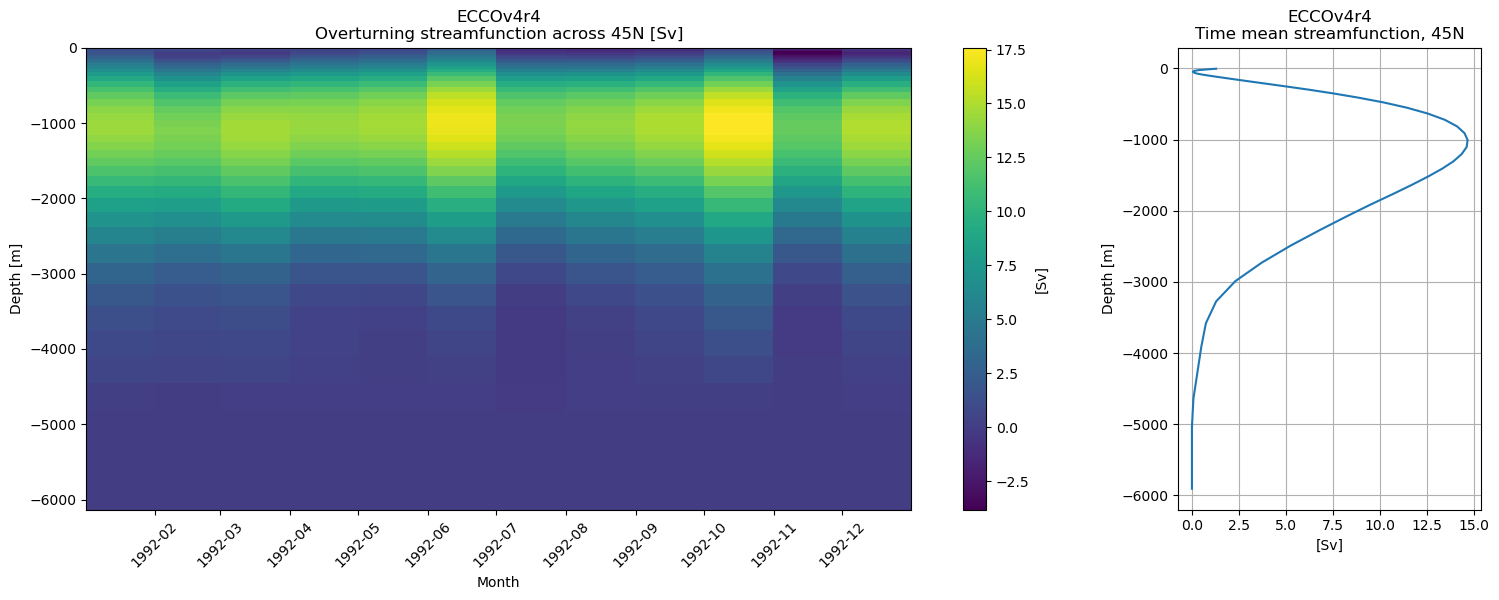

In [15]:
def depth_stf_vs_time(stf_ds,label):
    fig = plt.figure(figsize=(18,6))

    # Time evolving
    plt.subplot(1,4,(1,3))
    time_edge_extrap = np.hstack((stf_ds['time'].values[0] - (0.5*np.diff(stf_ds['time'].values[0:2])),\
                                  stf_ds['time'].values[:-1] + (0.5*np.diff(stf_ds['time'].values)),\
                                  stf_ds['time'].values[-1] + (0.5*np.diff(stf_ds['time'].values[-2:]))))
    Z_edge_extrap = np.hstack((np.array([0]),\
                               stf_ds['Z'].values[:-1] + (0.5*np.diff(stf_ds['Z'].values)),\
                               np.array([-6134.5])))
    plt.pcolormesh(time_edge_extrap, Z_edge_extrap,stf_ds['psi_moc'].T)
    plt.title('ECCOv4r5\nOverturning streamfunction across %s [Sv]' % label)
    plt.ylabel('Depth [m]')
    plt.xlabel('Month')
    plt.xticks(rotation=45)
    cb = plt.colorbar()
    cb.set_label('[Sv]')

    plt.subplot(1,4,4)
    plt.plot(stf_ds['psi_moc'].mean('time'),stf_ds['Z'])
    plt.title('ECCOv4r5\nTime mean streamfunction, %s' % label)
    plt.ylabel('Depth [m]')
    plt.xlabel('[Sv]')
    plt.grid()
    plt.show()

depth_stf_vs_time(moc_z.sel(lat=45),'45N')